In [1]:
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import time
import random

random.seed(1)

In [2]:
# DIP = pd.read_csv("DIP_Feature.csv")
AADIP = pd.read_csv("../AADIP/AADIP_Feature.csv")
# SPC = pd.read_csv("Spectrum_Feature.csv")
# AADIP = pd.read_csv("AADIP_Feature.csv")

/home/criesavian/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
AADIP = AADIP.drop('Unnamed: 0', axis=1)
AADIP.head()

,Gene,CDR3,V,J,Species,MHC A,Epitope,Epitope Species,Feature_0,Feature_1,...,Feature_8410,Feature_8411,Feature_8412,Feature_8413,Feature_8414,Feature_8415,Feature_8416,Feature_8417,Feature_8418,Feature_8419
0,TRA,IVVRSSNTGKLI00000000000000000000000000,TRAV26-1*01,TRAJ37*01,HomoSapiens,"HLA-E*01:01, HLA-E*01:03",VMAPRTLIL,Homo sapiens (human),0.000,2.632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRA,CAVRPTSGGSYIPTF00000000000000000000000,TRAV21*01,TRAJ6*01,HomoSapiens,HLA-A*02:01,SLLMWITQC,Homo sapiens (human),2.632,2.632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRA,TVYGGATNKLI000000000000000000000000000,TRAV26-2*01,TRAJ32*01,HomoSapiens,HLA-DRB1*04:01,LSRFSWGAEGQRPGFGYGG,Homo sapiens (human),2.632,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRA,TVYGGATNKLI000000000000000000000000000,TRAV26-2*01,TRAJ32*01,HomoSapiens,HLA-DRB1*04:01,LSRFSWGAEGQRPGFGYGG,Homo sapiens (human),2.632,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRA,AVRVTGGFKTI000000000000000000000000000,TCRAV1-2,TCRVJ9,HomoSapiens,human CD1b,6-deoxy-D-glucos-6-yl corynomycolate,Rhodococcus equi,2.632,2.632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
tcr_human = AADIP[AADIP["Gene"]=="TRB"]

In [5]:
def remove_symbol(data):
  data_temp1 = []
  data_temp2 = []
  
  data = data.reset_index(drop=True)  
    
  for i in range(data.shape[0]):    
    temp = str(data[i]).replace("*","")    
    data_temp1.append(temp)
  
  data_temp1 = np.asarray(data_temp1)

  for i in range(data_temp1.shape[0]):
    temp = data_temp1[i].replace("-","")
    data_temp2.append(temp)
  
  data_temp2 = np.asarray(data_temp2)
  return data_temp2

In [6]:
V = remove_symbol(tcr_human['V'])
J = remove_symbol(tcr_human['J'])

from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(V)

V = vle.transform(V)
V = V.reshape(-1, 1)

from sklearn import preprocessing
jle = preprocessing.LabelEncoder()
jle.fit(J)

J = jle.transform(J)
J = J.reshape(-1, 1)
print(V.shape, J.shape)

tcr_human['V']=V
tcr_human['J']=J

(201848, 1) (201848, 1)


/tmp/ipykernel_956/631406096.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcr_human['V']=V
/tmp/ipykernel_956/631406096.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcr_human['J']=J


In [7]:
# tcr_human.head()

In [8]:
# from sklearn import preprocessing
# ele = preprocessing.LabelEncoder()
# ele.fit(tcr_human['Epitope'])

# target = ele.transform(tcr_human['Epitope'])
# target = target.reshape(-1, 1)

# tcr_human['Epitope'] = target

In [9]:
tcr_human = tcr_human.reset_index(drop=True)
# tcr_human.head()

In [10]:
tcr = pd.concat([tcr_human.loc[:,"Feature_0":tcr_human.columns[-1]],tcr_human[['V','J','Epitope']]], axis = 1)
# tcr.head()

In [11]:
X = tcr.loc[:,"Feature_0":"J"]
y = tcr["Epitope"]

In [12]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=10)
X = transformer.fit_transform(X)

In [13]:
# tcr_human = tcr_human[tcr_human['Epitope'].isin(['NLVPMVATV', 'GILGFVFTL', 'GLCTLVAML'])]

In [14]:
#Show the highest value
epitope_counts = y[y == 'GLCTLVAML'].value_counts()
epitope_counts[:1]

GLCTLVAML    13245
Name: Epitope, dtype: int64

In [15]:
target_class = epitope_counts[:1].index

In [16]:
target_class

Index(['GLCTLVAML'], dtype='object')

In [17]:
def convert_target(target_raw, val):
    result = target_raw.copy()
    
    for i in range(result.shape[0]):
        if result[i] != val:
            result[i] = 0

        if result[i] == val:
            result[i] = 1
    
    result1 = pd.concat((pd.DataFrame(X),pd.DataFrame(result)), axis=1)
    
    r1 = result1[result1['Epitope']==1].sample(n = result1[result1['Epitope']==1].shape[0], random_state=np.random.RandomState(100))
    r2 = result1[result1['Epitope']==0].sample(n = result1[result1['Epitope']==1].shape[0], random_state=np.random.RandomState(100))
    
    result2 = np.concatenate((r1,r2), axis=0)
    
    return result2

In [18]:
for species in tqdm(target_class,'target'):
    label = convert_target(y,species)


X = label[:,:-1]
y = label[:,-1:]

target:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
label

array([[48.83189466204436, 15.08792609722583, 1.0564622562450077, ...,
        -3.2341328971441468, 3.909036904770103, 1],
       [-146.97188356698842, 2.0661185267321898, -4.472868753535864, ...,
        1.2670615765248927, -4.541156020735289, 1],
       [47.99823694331096, 17.311529868797845, 0.35714300563886914, ...,
        -3.53286855323586, 1.9993207820094607, 1],
       ...,
       [-1.593548536501911, -23.05488251779078, -3.097027340347306, ...,
        -0.7831699440017611, -1.6828552566799975, 0],
       [63.14747731186096, 6.920656384960146, -1.4861997870936805, ...,
        1.394723709803284, 1.1649562089862202, 0],
       [-57.0371512781763, -1.7946737773400954, 3.374613591605376, ...,
        -3.2495771170655483, 1.0542150009960012, 0]], dtype=object)

In [20]:
#Deep Learning

import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Activation, Flatten, GlobalAveragePooling1D,concatenate,Conv1D, Dropout, MaxPool1D, Flatten, AveragePooling1D, BatchNormalization, GlobalMaxPool1D, LeakyReLU, MaxPooling1D, Bidirectional
from tensorflow.keras.models import load_model, Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
from attention import Attention
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold 


import os

In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.keras code in this scope will run on GPU


2022-10-15 13:19:45.402789: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 13:19:47.807670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10342 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


In [22]:
n_classes = len(np.unique(y))
print(n_classes)

2


In [23]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=object), array([13245, 13245]))

In [24]:
n_classes = len(np.unique(y))
print(n_classes)

# X = X_new
y = y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
y = enc.transform(y).toarray()

2


In [25]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X,y)

precision_val = []
recall_val = []
specificity_val = []
sensitivity_val = []
f1score_val = []
accuracy_val = []
training_time = []
testing_time = []
testing_size = []
auc_val = []

randomIter = kf.split(X)

In [26]:
train_idx, test_idx = next(randomIter)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

        
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape, X_test.shape)

(21192, 10, 1) (5298, 10, 1)


In [27]:
from tensorflow.keras import layers


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_tensor,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = input_tensor
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="relu")(x)
    return keras.Model(inputs, outputs)


In [28]:
def run_model(X_train, X_test, y_train, y_test):
    #Watch this
    # opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
    epoch = 1000

    lr = 0.0001
    decay_rate = lr / epoch
    momentum = 0.8
    sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, decay=decay_rate, nesterov=False) # Nesterov = False
    adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=decay_rate, beta_2=decay_rate*decay_rate, epsilon=1e-07, amsgrad=False)
    checkpoint = ModelCheckpoint("AADIP_GLCT_TR.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', period=1)


    cdr_in = Input(shape=(X_train.shape[1], 1))

    # Transformer
    transformer = build_model(
      cdr_in,
      head_size=256,
      num_heads=4,
      ff_dim=4,
      num_transformer_blocks=4,
      mlp_units=[128],
      mlp_dropout=0.2,
      dropout=0.1,
    )

    # Convolutional
    # conv = Conv1D(8, kernel_size = 1)(cdr_in)
    # conv = Conv1D(16, kernel_size = 1, groups = 2)(conv)
    # conv = Conv1D(4, kernel_size = 1)(conv)

    # conv = MaxPooling1D(pool_size=1)(conv)
    # conv = Flatten()(conv)
    # conv_out = Dense(8, activation='relu')(conv)
    # conv_model = Model(cdr_in, conv_out)

    # Dense
    # merged = concatenate([transformer.output])
    dense = BatchNormalization()(transformer.output)

    dense = Dense(16,activation="LeakyReLU")(dense)
    dense = Dense(64,activation="LeakyReLU")(dense)
    dense = Dense(16,activation="LeakyReLU")(dense)
    dense = BatchNormalization()(dense)

    # model.add(Dropout(0.3))
    dense_out = Dense(n_classes, activation="softmax")(dense)

    # combine
    model = Model(cdr_in, dense_out)

    model.summary()

    # To my experience, the Stocastic Gradient Descent Optimizer works the best. Adam optimizer also works but not as good as SGD
    optimizer = adam
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy', 'AUC'])
    history = model.fit(X_train, y_train,  batch_size=128, epochs=epoch, validation_data=(X_test, y_test),callbacks=[checkpoint,PlotLossesKeras(),EarlyStopping(monitor='val_loss', patience=10)],verbose=1)

    return model

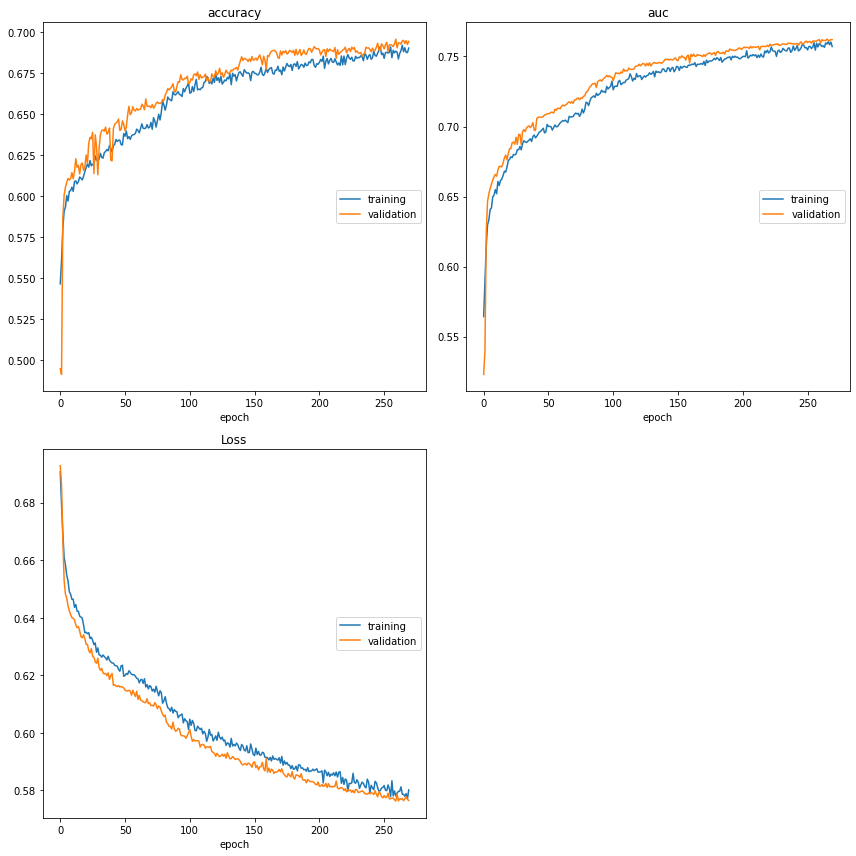

accuracy
	training         	 (min:    0.546, max:    0.692, cur:    0.690)
	validation       	 (min:    0.491, max:    0.696, cur:    0.694)
auc
	training         	 (min:    0.564, max:    0.761, cur:    0.757)
	validation       	 (min:    0.523, max:    0.762, cur:    0.762)
Loss
	training         	 (min:    0.577, max:    0.691, cur:    0.580)
	validation       	 (min:    0.576, max:    0.693, cur:    0.576)
166/166 [==============================] - 5s 32ms/step - loss: 0.5802 - accuracy: 0.6901 - auc: 0.7571 - val_loss: 0.5765 - val_accuracy: 0.6942 - val_auc: 0.7620


In [29]:
#Fold 1
start = time.time()
model = run_model(X_train, X_test, y_train, y_test)
end = time.time()
training_time.append(end-start)

In [30]:
# model.save('model_fusion_TransformerConv')

In [31]:
# pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1])).to_csv("GILG_Xtest.csv", index=False)
# pd.DataFrame(y_test).to_csv("GILG_ytest.csv", index=False)

In [32]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
testing_time.append(end-start)
testing_size.append(X_test.shape)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision_val.append(precision_score(y_true, y_pred, average='weighted'))
recall_val.append(recall_score(y_true, y_pred, average='weighted'))
auc_val.append(roc_auc_score(y_true, y_pred, average='weighted'))

cm = multilabel_confusion_matrix(y_true, y_pred)

a = []

for i in range(len(cm)):
    a.append(cm[i].ravel())

tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

specificity_val.append(tn / (tn+fp)) #specificity
sensitivity_val.append(tp / (tp+fn)) #sensitivity 

f1score_val.append(f1_score(y_true, y_pred, average='weighted'))
accuracy_val.append(accuracy_score(y_true, y_pred))


In [33]:
train_idx, test_idx = next(randomIter)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
        
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape, X_test.shape)

(21192, 10, 1) (5298, 10, 1)


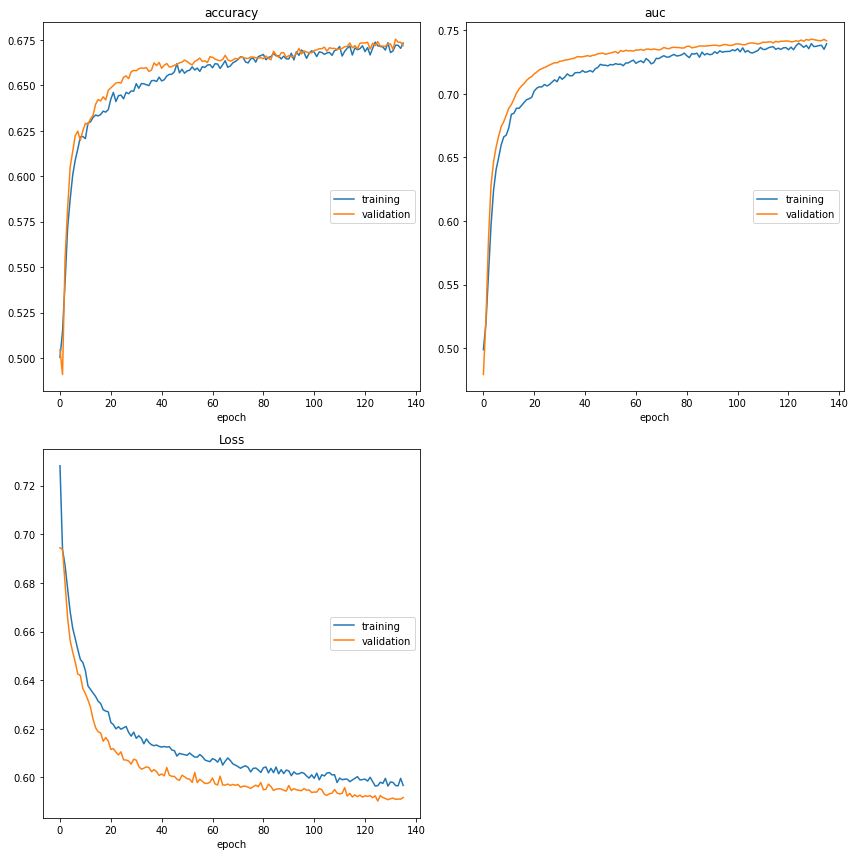

accuracy
	training         	 (min:    0.500, max:    0.674, cur:    0.673)
	validation       	 (min:    0.491, max:    0.675, cur:    0.672)
auc
	training         	 (min:    0.499, max:    0.740, cur:    0.739)
	validation       	 (min:    0.479, max:    0.743, cur:    0.742)
Loss
	training         	 (min:    0.596, max:    0.728, cur:    0.597)
	validation       	 (min:    0.590, max:    0.694, cur:    0.592)
166/166 [==============================] - 5s 33ms/step - loss: 0.5967 - accuracy: 0.6732 - auc: 0.7394 - val_loss: 0.5918 - val_accuracy: 0.6718 - val_auc: 0.7417


In [34]:
#Fold 2
start = time.time()
model = run_model(X_train, X_test, y_train, y_test)
end = time.time()
training_time.append(end-start)

In [35]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
testing_time.append(end-start)
testing_size.append(X_test.shape)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision_val.append(precision_score(y_true, y_pred, average='weighted'))
recall_val.append(recall_score(y_true, y_pred, average='weighted'))
auc_val.append(roc_auc_score(y_true, y_pred, average='weighted'))


cm = multilabel_confusion_matrix(y_true, y_pred)

a = []

for i in range(len(cm)):
    a.append(cm[i].ravel())

tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

specificity_val.append(tn / (tn+fp)) #specificity
sensitivity_val.append(tp / (tp+fn)) #sensitivity 

f1score_val.append(f1_score(y_true, y_pred, average='weighted'))
accuracy_val.append(accuracy_score(y_true, y_pred))

In [36]:
train_idx, test_idx = next(randomIter)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
        
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape, X_test.shape)

(21192, 10, 1) (5298, 10, 1)


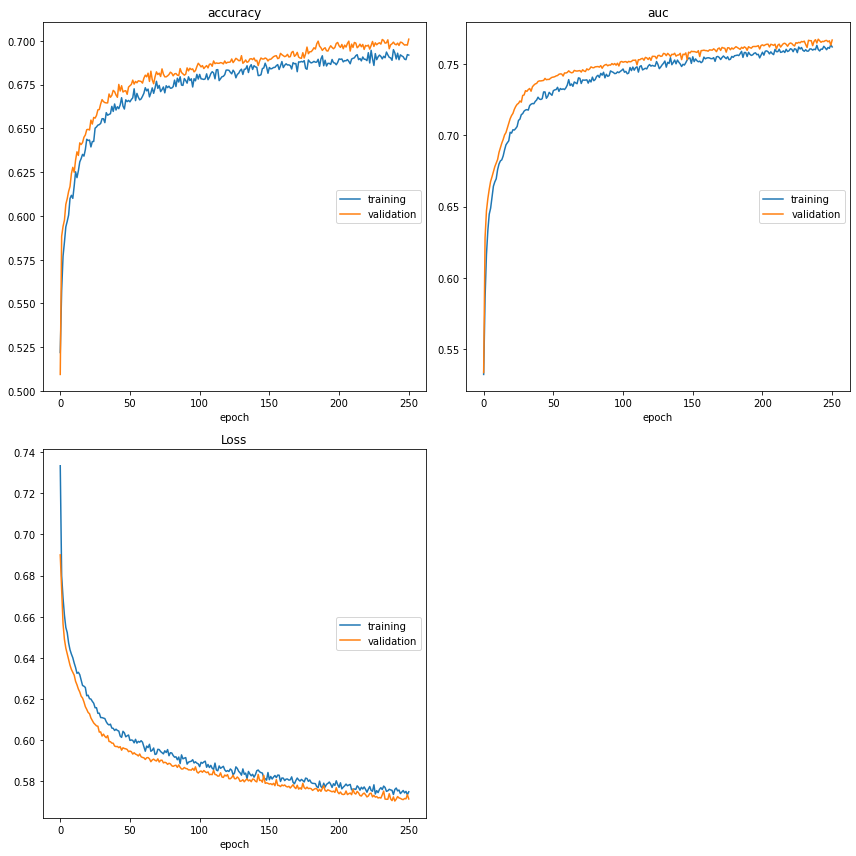

accuracy
	training         	 (min:    0.522, max:    0.695, cur:    0.692)
	validation       	 (min:    0.509, max:    0.701, cur:    0.701)
auc
	training         	 (min:    0.532, max:    0.763, cur:    0.762)
	validation       	 (min:    0.534, max:    0.767, cur:    0.767)
Loss
	training         	 (min:    0.574, max:    0.733, cur:    0.575)
	validation       	 (min:    0.570, max:    0.690, cur:    0.571)
166/166 [==============================] - 5s 32ms/step - loss: 0.5750 - accuracy: 0.6919 - auc: 0.7618 - val_loss: 0.5715 - val_accuracy: 0.7010 - val_auc: 0.7666


In [37]:
#Fold 3
start = time.time()
model = run_model(X_train, X_test, y_train, y_test)
end = time.time()
training_time.append(end-start)

In [38]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
testing_time.append(end-start)
testing_size.append(X_test.shape)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision_val.append(precision_score(y_true, y_pred, average='weighted'))
recall_val.append(recall_score(y_true, y_pred, average='weighted'))
auc_val.append(roc_auc_score(y_true, y_pred, average='weighted'))


cm = multilabel_confusion_matrix(y_true, y_pred)

a = []

for i in range(len(cm)):
    a.append(cm[i].ravel())

tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

specificity_val.append(tn / (tn+fp)) #specificity
sensitivity_val.append(tp / (tp+fn)) #sensitivity 

f1score_val.append(f1_score(y_true, y_pred, average='weighted'))
accuracy_val.append(accuracy_score(y_true, y_pred))

In [39]:
train_idx, test_idx = next(randomIter)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
        
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape, X_test.shape)

(21192, 10, 1) (5298, 10, 1)


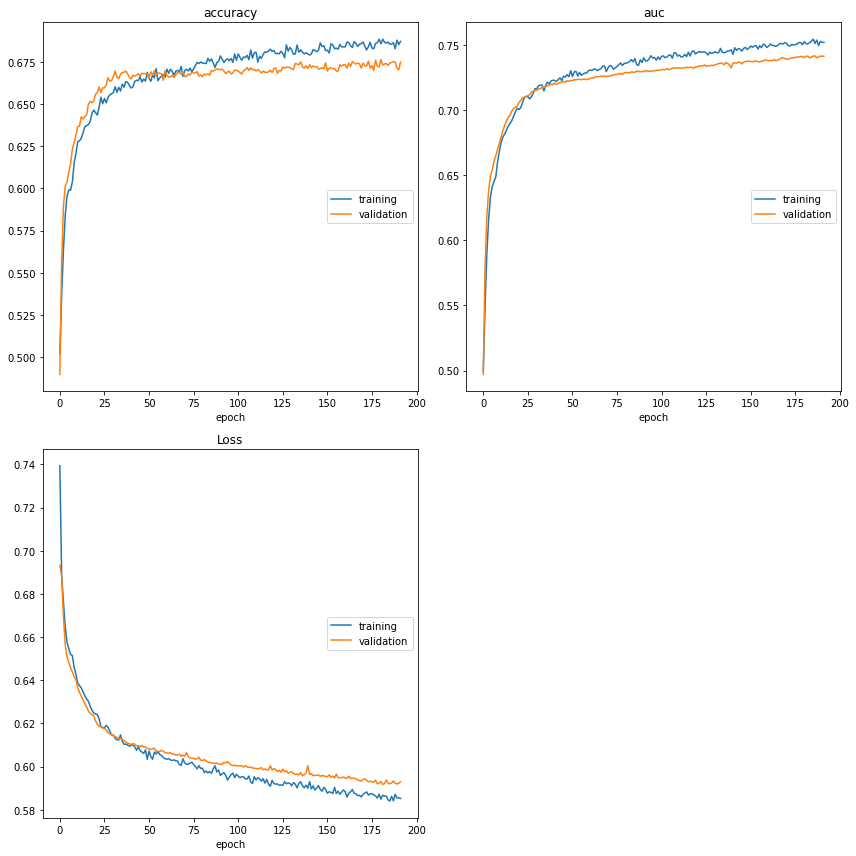

accuracy
	training         	 (min:    0.502, max:    0.689, cur:    0.687)
	validation       	 (min:    0.490, max:    0.676, cur:    0.675)
auc
	training         	 (min:    0.499, max:    0.754, cur:    0.752)
	validation       	 (min:    0.497, max:    0.741, cur:    0.741)
Loss
	training         	 (min:    0.584, max:    0.739, cur:    0.585)
	validation       	 (min:    0.592, max:    0.693, cur:    0.593)
166/166 [==============================] - 5s 31ms/step - loss: 0.5853 - accuracy: 0.6873 - auc: 0.7518 - val_loss: 0.5930 - val_accuracy: 0.6750 - val_auc: 0.7411


In [40]:
#Fold 4
start = time.time()
model = run_model(X_train, X_test, y_train, y_test)
end = time.time()
training_time.append(end-start)

In [41]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
testing_time.append(end-start)
testing_size.append(X_test.shape)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision_val.append(precision_score(y_true, y_pred, average='weighted'))
recall_val.append(recall_score(y_true, y_pred, average='weighted'))
auc_val.append(roc_auc_score(y_true, y_pred, average='weighted'))


cm = multilabel_confusion_matrix(y_true, y_pred)

a = []

for i in range(len(cm)):
    a.append(cm[i].ravel())

tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

specificity_val.append(tn / (tn+fp)) #specificity
sensitivity_val.append(tp / (tp+fn)) #sensitivity 

f1score_val.append(f1_score(y_true, y_pred, average='weighted'))
accuracy_val.append(accuracy_score(y_true, y_pred))

In [42]:
train_idx, test_idx = next(randomIter)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
        
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape, X_test.shape)

(21192, 10, 1) (5298, 10, 1)


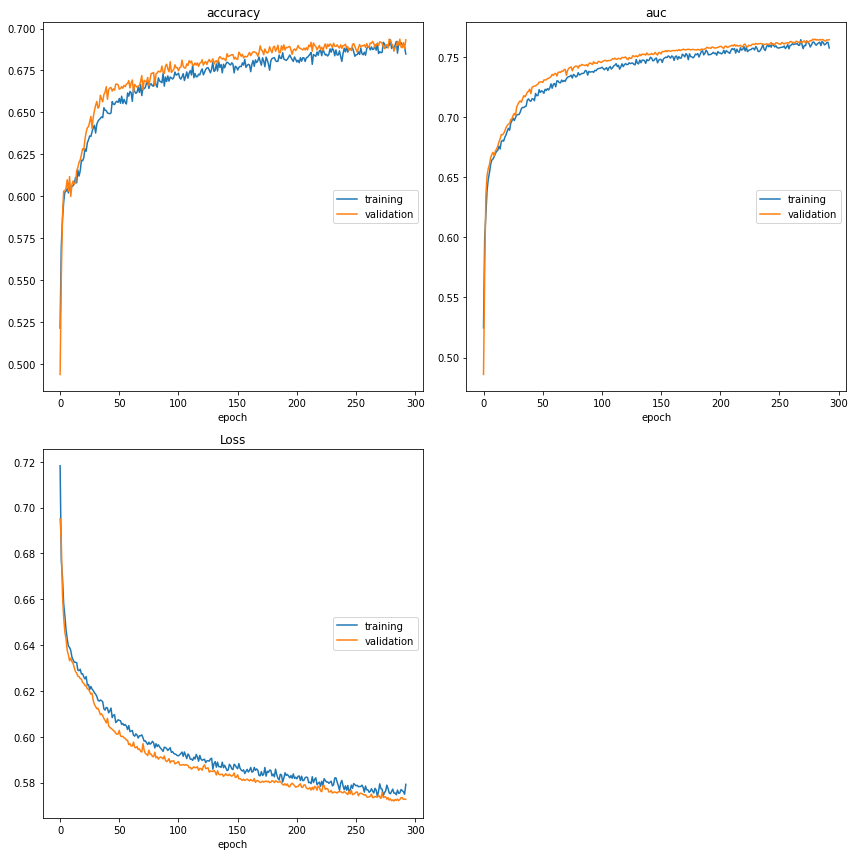

accuracy
	training         	 (min:    0.521, max:    0.693, cur:    0.685)
	validation       	 (min:    0.494, max:    0.694, cur:    0.693)
auc
	training         	 (min:    0.525, max:    0.765, cur:    0.758)
	validation       	 (min:    0.486, max:    0.765, cur:    0.765)
Loss
	training         	 (min:    0.574, max:    0.718, cur:    0.579)
	validation       	 (min:    0.572, max:    0.695, cur:    0.573)
166/166 [==============================] - 5s 31ms/step - loss: 0.5793 - accuracy: 0.6848 - auc: 0.7578 - val_loss: 0.5727 - val_accuracy: 0.6933 - val_auc: 0.7646


In [43]:
#Fold 5
start = time.time()
model = run_model(X_train, X_test, y_train, y_test)
end = time.time()
training_time.append(end-start)

In [44]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
testing_time.append(end-start)
testing_size.append(X_test.shape)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision_val.append(precision_score(y_true, y_pred, average='weighted'))
recall_val.append(recall_score(y_true, y_pred, average='weighted'))
auc_val.append(roc_auc_score(y_true, y_pred, average='weighted'))


cm = multilabel_confusion_matrix(y_true, y_pred)

a = []

for i in range(len(cm)):
    a.append(cm[i].ravel())

tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

specificity_val.append(tn / (tn+fp)) #specificity
sensitivity_val.append(tp / (tp+fn)) #sensitivity 

f1score_val.append(f1_score(y_true, y_pred, average='weighted'))
accuracy_val.append(accuracy_score(y_true, y_pred))

In [45]:
temp = precision_val, np.mean(precision_val), recall_val, np.mean(recall_val), specificity_val, np.mean(specificity_val), sensitivity_val, np.mean(sensitivity_val), f1score_val, np.mean(f1score_val), accuracy_val, np.mean(accuracy_val), auc_val, np.mean(auc_val), training_time, testing_time, testing_size
print(temp)

Data_Save = []
Data_Save.append(temp)
pd.DataFrame(Data_Save).to_csv('data_AADIP_GLCT-TR_PCA5.csv')

([0.697758953032317, 0.6833387237747374, 0.7081046227969864, 0.683838586724897, 0.7044332666796481], 0.6954948306017171, [0.6942242355605889, 0.6717629294073235, 0.7010192525481314, 0.6749716874292185, 0.693280483201208], 0.6870517176292941, [0.6942242355605889, 0.6717629294073235, 0.7010192525481314, 0.6749716874292185, 0.693280483201208], 0.6870517176292941, [0.6942242355605889, 0.6717629294073235, 0.7010192525481314, 0.6749716874292185, 0.693280483201208], 0.6870517176292941, [0.6925951606079042, 0.6667336614199219, 0.6977711778198715, 0.6717119175553142, 0.6894348236781715], 0.6836493482162366, [0.6942242355605889, 0.6717629294073235, 0.7010192525481314, 0.6749716874292185, 0.693280483201208], 0.6870517176292941, [0.6937381116984095, 0.6721355874910238, 0.6996453059156302, 0.6760858906897594, 0.6940031455432247], 0.6871216082676094, [1430.2614922523499, 722.0698964595795, 1323.7498483657837, 1022.616197347641, 1544.3464381694794], [1.4030563831329346, 1.4668571949005127, 1.47063469